버전 확인 및 라이브러리 설치

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
!head /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0


In [3]:
!nvidia-smi

Mon Jul 24 14:08:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Install MMCV
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0rc1"
!pip install "mmdet>=3.0.0rc4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.7 MB/s eta 0:00:00


In [5]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 15757, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 15757 (delta 38), reused 90 (delta 19), pack-reused 15625
Receiving objects: 100% (15757/15757), 20.98 MiB | 18.14 MiB/s, done.
Resolving deltas: 100% (11048/11048), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [1]:
%cd mmsegmentation

/content/mmsegmentation


In [2]:
import os
import os.path as osp
import shutil

from tqdm.auto import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch, torchvision

import mmcv
import mmseg

In [ ]:
print(torch.__version__, torch.cuda.is_available())
print(mmseg.__version__)

2.0.1+cu118 True
1.1.0


데이터 압축해제 및 폴더 생성

In [7]:
!unzip -qq /content/drive/MyDrive/data.zip

In [3]:
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape)
    return img

# RLE 인코딩 함수
def rle_encode(mask):

    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [4]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class BuildingSegDataset(BaseSegDataset):
  METAINFO = dict(
      classes=("bg", "building"),
      palette=([128, 0, 0], [0, 128, 0])
  )
  def __init__(self,
               img_suffix=".png",
               seg_map_suffix=".png",
               **kwargs):
    super().__init__(
        img_suffix=img_suffix,
        seg_map_suffix=seg_map_suffix,
        **kwargs)


Creat Config File

In [5]:
from mmengine import Config
cfg = Config.fromfile('configs/mask2former/mask2former_swin-b-in22k-384x384-pre_8xb2-160k_ade20k-640x640.py')
# print(f'Config:\n{cfg.pretty_text}')

In [6]:
# mask2former
epoch = 40
data_root = "data"
cfg.num_classes = 2

# cfg.load_from = "/content/drive/MyDrive/best_mIoU_iter_21450.pth"
# cfg.resume = True

cfg.model.decode_head.num_classes = cfg.num_classes
cfg.model.decode_head.out_channels = 2
# cfg.model.decode_head.loss_cls.use_sigmoid = True
# cfg.model.decode_head.loss_cls = dict(type="FocalLoss", loss_weight=2.0, reduction='mean')
cfg.model.decode_head.loss_cls = dict(
            type='mmdet.CrossEntropyLoss',
            use_sigmoid=False,
            loss_weight=2.0,
            reduction='mean',
            class_weight=[0.5, 1.0] + [0.1])


# Modify dataset type and path
cfg.dataset_type = 'BuildingSegDataset'
cfg.data_root = data_root
cfg.crop_size = (640, 640)

# train : 7141 * 0.8 -> 5713
# 5713 / 2 -> 2856 iter == 1 epoch

cfg.train_cfg.type = "IterBasedTrainLoop"
cfg.train_cfg.max_iters = 2856 * epoch
cfg.train_cfg.val_interval = 2856 * 2

cfg.default_hooks.logger.interval = 1000
cfg.default_hooks.checkpoint.interval = 2856 * 2
cfg.default_hooks.checkpoint.max_keep_ckpts = 5

cfg.optim_wrapper.type = "AmpOptimWrapper"
cfg.optim_wrapper.accumulative_counts = 2


albu_train_transforms = [
    dict(type="RandomRotate90", p=0.5),
    dict(
      type='OneOf',
      transforms=[
          dict(type='RandomBrightnessContrast', brightness_limit=0.1, contrast_limit=0.15, p=1.0),
          dict(type='Blur', p=1.0),
          dict(type='GaussNoise', p=1.0),
          dict(type='GaussianBlur', p=1.0),
          dict(type='MedianBlur', blur_limit=5, p=1.0),
      ], p=0.3
    )
]

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(
        type='RandomChoiceResize',
        scales=[int(1024 * x * 0.1) for x in range(7, 25)],
        resize_type='ResizeShortestEdge',
        max_size=4096),
    # dict(type="Albu", transforms=albu_train_transforms),
    dict(type="RandomRotate", prob=0.5, degree=90),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type="RandomCutOut", prob=0.5, n_holes=(1, 3), cutout_shape=[(size, size) for size in [50, 100, 150]]),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs'),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(640, 640), keep_ratio=True),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(type='PackSegInputs'),
]


cfg.train_dataloader.num_workers = 3
cfg.train_dataloader.batch_size = 2
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.data_prefix = dict(img_path="images/train", seg_map_path="annotations/train")


cfg.val_dataloader.num_workers = 3
cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.data_prefix = dict(img_path="images/val", seg_map_path="annotations/val")

cfg.test_dataloader.num_workers = 3
cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.data_prefix = dict(img_path="images/val", seg_map_path="annotations/val")



cfg['randomness'] = dict(seed=42)
cfg.work_dir = './work_dirs/mask2former'

print(f'Config:\n{cfg.pretty_text}')

Config:
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'))
vis_backends = [
    dict(type='LocalVisBackend'),
]
visualizer = dict(
    type='SegLocalVisualizer',
    vis_backends=[
        dict(type='LocalVisBackend'),
    ],
    name='visualizer')
log_processor = dict(by_epoch=False)
log_level = 'INFO'
load_from = None
resume = False
tta_model = dict(type='SegTTAModel')
dataset_type = 'BuildingSegDataset'
data_root = 'data'
crop_size = (
    640,
    640,
)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(
        type='RandomChoiceResize',
        scales=[
            716,
            819,
            921,
            1024,
            1126,
            1228,
            1331,
            1433,
            1536,
            1638,
            1740,
            1843,
            1945,
            2048,

In [16]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

07/24 14:34:18 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
    CUDA available: True
    numpy_random_seed: 42
    GPU 0: Tesla V100-SXM2-16GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=comp

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


07/24 14:34:29 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/24 14:34:29 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [17]:
runner.train()

/content/mmsegmentation/mmseg/datasets/transforms/loading.py:83: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '


07/24 14:34:36 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:lr=1e-05
07/24 14:34:36 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:weight_decay=0.05
07/24 14:34:36 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:lr_mult=0.1
07/24 14:34:36 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:decay_mult=1.0
07/24 14:34:36 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:lr=1e-05
07/24 14:34:36 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:weight_decay=0.05
07/24 14:34:36 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:lr_mult=0.1
07/24 14:34:36 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:decay_mult=1.0
07/24 14:34:36 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:lr=1e-05
07/24 14:34:36 - mmengine - INFO - paramwi

Downloading: "https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_base_patch4_window12_384_22k_20220317-e5c09f74.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window12_384_22k_20220317-e5c09f74.pth


07/24 14:35:09 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/24 14:35:09 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/24 14:35:09 - mmengine - INFO - Checkpoints will be saved to /content/mmsegmentation/work_dirs/mask2former.


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/mmengine/optim/scheduler/param_scheduler.py:198: UserWarning: Detected call of `scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `scheduler.step()`. Failure to do this will result in PyTorch skipping the first value of the parameter value schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


07/24 14:42:48 - mmengine - INFO - Exp name: mask2former_swin-b-in22k-384x384-pre_8xb2-160k_ade20k-640x640_20230724_143418
07/24 14:42:48 - mmengine - INFO - Iter(train) [  1000/114240]  base_lr: 9.9438e-05 lr: 9.9438e-06  eta: 14:26:03  time: 0.4407  data_time: 0.0144  memory: 12887  loss: 21.9185  decode.loss_cls: 0.0020  decode.loss_mask: 1.0180  decode.loss_dice: 1.0481  decode.d0.loss_cls: 1.3306  decode.d0.loss_mask: 0.9857  decode.d0.loss_dice: 1.0710  decode.d1.loss_cls: 0.0138  decode.d1.loss_mask: 0.9946  decode.d1.loss_dice: 1.0565  decode.d2.loss_cls: 0.0086  decode.d2.loss_mask: 1.0144  decode.d2.loss_dice: 1.0430  decode.d3.loss_cls: 0.0068  decode.d3.loss_mask: 0.9978  decode.d3.loss_dice: 1.0374  decode.d4.loss_cls: 0.0080  decode.d4.loss_mask: 1.0111  decode.d4.loss_dice: 1.0419  decode.d5.loss_cls: 0.0059  decode.d5.loss_mask: 1.0093  decode.d5.loss_dice: 1.0521  decode.d6.loss_cls: 0.0035  decode.d6.loss_mask: 1.0012  decode.d6.loss_dice: 1.0497  decode.d7.loss_cls: 

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0-1): 2 x SwinBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
 

inference

In [7]:
!mv work_dirs/mask2former/best_mIoU_iter_91392.pth /content/drive/MyDrive/mask2former_640_iter_91392.pth

In [8]:
!unzip -qq /content/drive/MyDrive/test_img.zip -d data/

Loads checkpoint by local backend from path: /content/drive/MyDrive/mask2former_640_iter_91392.pth
07/25 06:18:22 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


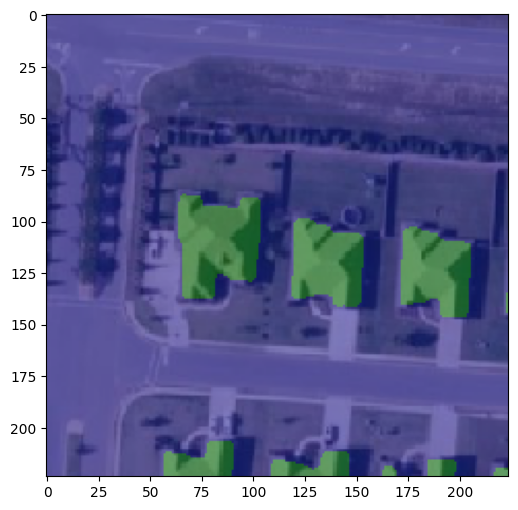

In [10]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = '/content/drive/MyDrive/mask2former_640_iter_91392.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('./data/test_img/TEST_00000.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

In [11]:
submit = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")

In [12]:
mask_lst = []
for idx, row in tqdm(submit.iterrows(), total=len(submit["img_id"])):
  img = mmcv.imread(f"./data/test_img/{row['img_id']}.png")
  result = inference_model(model, img)
  mask = result.pred_sem_seg.data
  mask = mask.detach().cpu().numpy()
  mask = rle_encode(mask)
  if mask == '':
    mask = -1
  mask_lst.append(mask)
submit["mask_rle"] = mask_lst
submit.to_csv("answer.csv", index=False)

  0%|          | 0/60640 [00:00<?, ?it/s]

In [13]:
!mv answer.csv /content/drive/MyDrive/mask2former_640_30epoch.csv